<a href="https://colab.research.google.com/github/ahliminha/P300/blob/master/P300.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
!pip3 install mat4py

In [107]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy.io as sio
from mat4py import loadmat 
from keras.utils import to_categorical
import time
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [0]:
np.random.seed(816)
device = tf.test.gpu_device_name()

In [0]:
folder = '/content/drive/My Drive/IC/*.mat'
files = glob.glob(folder)
files.pop(0) #drop the data badly structured
test_file = files.pop(0) #last subject for testing the network

In [111]:
print(files)

['/content/drive/My Drive/IC/P300S03.mat', '/content/drive/My Drive/IC/P300S04.mat', '/content/drive/My Drive/IC/P300S05.mat', '/content/drive/My Drive/IC/P300S06.mat', '/content/drive/My Drive/IC/P300S07.mat', '/content/drive/My Drive/IC/P300S08.mat']


In [0]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 24.0       # sample rate, Hz
cutoff = 1.5  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

In [0]:
def prepare_data(file):
  allX = []
  allY = []
  allT = []
  allF = []
  raw_data = loadmat(file)
  useful_data = raw_data['data'].copy()
  X = useful_data['X']
  Y = useful_data['y']
  T = useful_data['trial']
  F = useful_data['flash']
  # X_mean = np.mean(X, axis=1)
  X_filtered = butter_lowpass_filter(X, cutoff, fs, order)
  
  return X_filtered, Y, T, F

In [0]:
def normalized(vec):
  norm_vec = (vec - vec.min(axis=1, keepdims=True))/vec.ptp(axis=1, keepdims=True)
  return norm_vec

In [0]:
def clean_data(X, Y, flash):
  
  X_samples = np.array([np.array(X[i[0]:i[0]+351]) for i in flash] )
  column    = [i[2] for i in flash]
  label     = [i[3] - 1 for i in flash]
  
  LIMIT = 4080 #the last trial is incomplete
  X_selected = np.array(X_samples[:LIMIT])
  col_selected = np.array(column[:LIMIT])
  label_selected = np.array(label[:LIMIT])

  y = np.array(to_categorical(label_selected))

  false_idx = [k for k, i in enumerate(y) if i[0] == 1]
  true_idx  = [k for k, i in enumerate(y) if i[0] == 0]

  falseX = X_selected[false_idx]
  falsey = y[false_idx]

  trueX  = X_selected[true_idx]  
  truey  = y[true_idx]
  # proportional data to avoid greedy cost funtion

  proportionalX = falseX[:int(len(trueX))]
  proportionaly = falsey[:int(len(truey))]

  finalX = np.concatenate((trueX, proportionalX))
  finaly = np.concatenate((truey, proportionaly))

  X_timeseries = np.vstack(finalX)
  X_letters = X_timeseries.reshape(34,40,351,8)
  y_letters = finaly.reshape(34,40,2)
  cleaned_X = np.vstack(X_letters)
  cleaned_Y = np.vstack(y_letters)
  
  return cleaned_X, cleaned_Y

In [132]:
import tensorflow as tf

from tensorflow import keras
tf.keras.backend.clear_session()  # For easy reset of notebook state.

from tensorflow.keras import layers

input_layer = keras.Input(shape = (351,8,1), name='main_input')
x     = layers.Conv2D(16, 8, padding='same', activation='relu')(input_layer)
x     = layers.Conv2D(32, 6, padding='same', activation='relu')(x)
x     = layers.Conv2D(8, 4, padding='same', activation='relu')(x)
x     = layers.Conv2D(4, 2, padding='same', activation='relu')(x)
x     = layers.GlobalAveragePooling2D()(x)
x     = layers.Dense(8)(x)
x     = layers.Dense(64)(x)
output = layers.Dense(2, activation='softmax')(x)

model = keras.Model(inputs=input_layer, outputs=output)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 351, 8, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 351, 8, 16)        1040      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 351, 8, 32)        18464     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 351, 8, 8)         4104      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 351, 8, 4)         132       
_________________________________________________________________
global_average_pooling2d (Gl (None, 4)                 0         
_________________________________________________________________
dense (Dense)                (None, 8)                 40    

In [0]:
#compiling the model
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)  # default params
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [0]:
def train_net(model):
  appX = []
  appy = []
  init = time.time()
  for file in files:
    X, Y, Trials, Flash = prepare_data(file)
    X_clean, y_clean = clean_data(X, Y, Flash)
    appX.append(X_clean)
    appy.append(y_clean)

  X = [subject for subject in appX]
  y = [subject for subject in appy]
  X_train, X_valid, y_train, y_valid = train_test_split(np.vstack(X), np.vstack(y), test_size=0.1, random_state=816)
  history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=30, epochs=20, verbose=1)
  end = time.time()
  print("time elapsed training is:", (end - init)/60, " minutes")  
  return history.history['accuracy'], history.history['val_accuracy'], history.history['loss'], history.history['val_loss']

In [135]:
acc, val_acc, loss, val_loss = train_net(model)

Epoch 1/20
245/245 [==============================] - 6s 25ms/step - loss: 0.6915 - accuracy: 0.5173 - val_loss: 0.6823 - val_accuracy: 0.6054
Epoch 2/20
245/245 [==============================] - 6s 24ms/step - loss: 0.6841 - accuracy: 0.5577 - val_loss: 0.6817 - val_accuracy: 0.5466
Epoch 3/20
245/245 [==============================] - 6s 24ms/step - loss: 0.6800 - accuracy: 0.5723 - val_loss: 0.6727 - val_accuracy: 0.6091
Epoch 4/20
245/245 [==============================] - 6s 24ms/step - loss: 0.6784 - accuracy: 0.5731 - val_loss: 0.6735 - val_accuracy: 0.5919
Epoch 5/20
245/245 [==============================] - 6s 24ms/step - loss: 0.6771 - accuracy: 0.5776 - val_loss: 0.6795 - val_accuracy: 0.5453
Epoch 6/20
245/245 [==============================] - 6s 24ms/step - loss: 0.6779 - accuracy: 0.5753 - val_loss: 0.6732 - val_accuracy: 0.5735
Epoch 7/20
245/245 [==============================] - 6s 24ms/step - loss: 0.6771 - accuracy: 0.5788 - val_loss: 0.6750 - val_accuracy: 0.5588

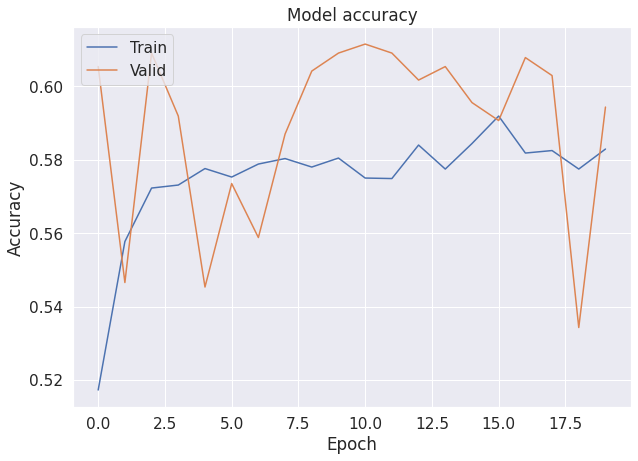

In [136]:
# Plot test accuracy values
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()


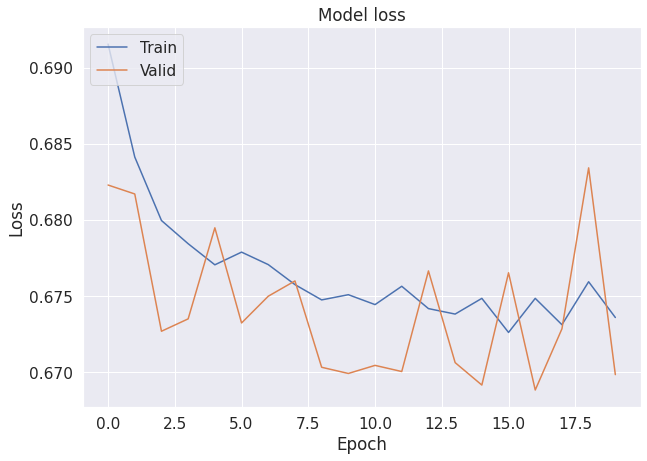

In [137]:
# Plot test accuracy values
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()


In [138]:
X, Y, Trials, Flash = prepare_data(test_file)
X_clean, y_clean = clean_data(X, Y, Flash)
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.1, random_state=816)
history = model.fit(X_train, y_train, batch_size=1, epochs=20)

Epoch 1/20
1224/1224 [==============================] - 7s 5ms/step - loss: 0.6944 - accuracy: 0.5188
Epoch 2/20
1224/1224 [==============================] - 7s 5ms/step - loss: 0.6708 - accuracy: 0.5940
Epoch 3/20
1224/1224 [==============================] - 7s 5ms/step - loss: 0.6362 - accuracy: 0.6683
Epoch 4/20
1224/1224 [==============================] - 7s 5ms/step - loss: 0.5757 - accuracy: 0.7263
Epoch 5/20
1224/1224 [==============================] - 7s 5ms/step - loss: 0.5522 - accuracy: 0.7361
Epoch 6/20
1224/1224 [==============================] - 7s 5ms/step - loss: 0.5255 - accuracy: 0.7655
Epoch 7/20
1224/1224 [==============================] - 7s 5ms/step - loss: 0.5308 - accuracy: 0.7680
Epoch 8/20
1224/1224 [==============================] - 7s 5ms/step - loss: 0.5225 - accuracy: 0.7614
Epoch 9/20
1224/1224 [==============================] - 7s 5ms/step - loss: 0.5166 - accuracy: 0.7786
Epoch 10/20
1224/1224 [==============================] - 7s 5ms/step - loss: 0.512

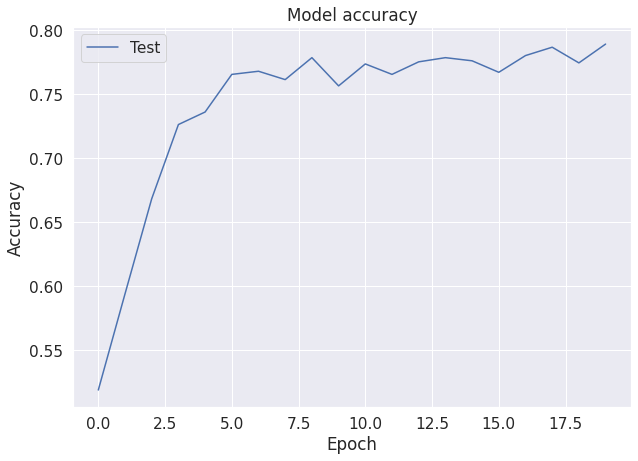

In [139]:
# Plot test accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Test'], loc='upper left')
plt.show()


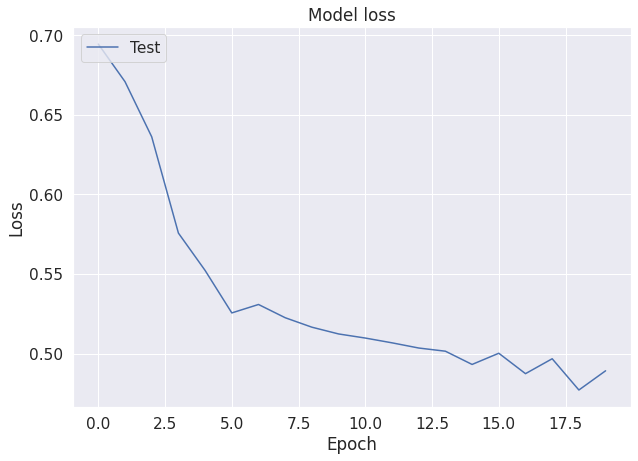

In [140]:
# Plot test loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test'], loc='upper left')
plt.show()

In [141]:
score = model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 9ms/step - loss: 0.5550 - accuracy: 0.7132


In [142]:
init = time.time()
preds = model.predict(X_test)
end = time.time()
print("time elapsed for each trial is:",(end - init)/X_test.shape[0] * 1000, "ms")

time elapsed for each trial is: 1.039222759359023 ms


In [0]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))

In [0]:
matrix_norm = np.zeros((2,2))
for i in range(2):
  matrix_norm[i] = matrix[i]/matrix[i].sum(axis=0)

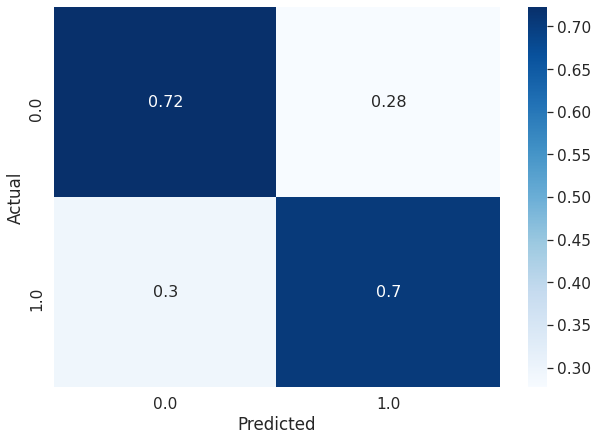

In [145]:
import seaborn as sns
df_cm = pd.DataFrame(matrix_norm, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

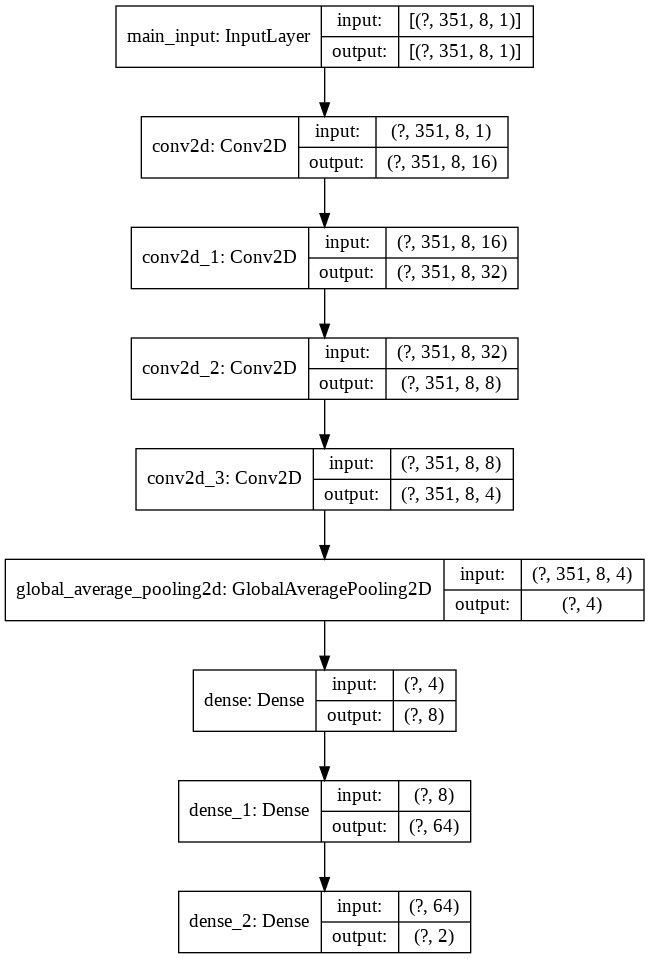

In [146]:
keras.utils.plot_model(model, '2DConv_model.png', show_shapes=True)

In [0]:
model.save('my_model.h5') 